In [1]:
using PyPlot; using MDToolbox;
using StatsBase; # for calculating histogram
using Printf; using DelimitedFiles;
using Distributions;
using LinearAlgebra;
PyPlot.plt[:style][:use]("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[1]:6
└ @ Core In[1]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[1]:6
└ @ Core In[1]:6


In [2]:
# setup constants
KBT = KB_kcalpermol*300.0
sigma = 6.0

6.0

In [3]:
# umbrella window centers
umbrella_centers = 0:3:180
K = length(umbrella_centers)

61

In [4]:
# define edges for histogram bin
M = 80; # number of bins
edge = range(-1, stop=181, length=M+1)
#edge = linspace(-1, 181, M+1)
bin_center = 0.5 .* (edge[2:end] .+ edge[1:(end-1)])

0.1375:2.275:179.8625

In [5]:
# read dihedral angle data
data_k = []
for k = 1:K
  filename = @sprintf "data/umbrella_alat/3_prod/run_%d.dat" umbrella_centers[k]
  x = readdlm(filename);
  push!(data_k, x[:, 2])
end

In [6]:
include("Density.jl")

get_gaussian (generic function with 1 method)

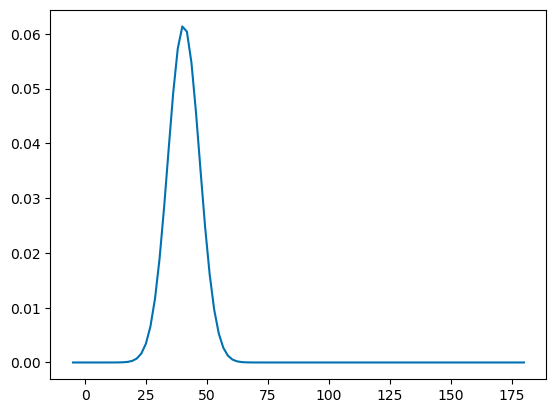

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13af44cc0>

In [13]:
# hist(data_k[1], 10)
p = range(-5, stop = 180, length = 100)
p_density = calc_densities(p, data_k[15], sigma)
plot(p, p_density)

In [14]:
# ΔWの計算

include("PotentialOfMeanForce.jl")
delta_pmf = []
for i = 1:K
    for j = 1:length(data_k[i])
        push!(delta_pmf, calc_delta_potential_of_mean_force(umbrella_centers[i], data_k[i], sigma, KBT, data_k[i][j]))
    end
end

In [15]:
# 設計行列の計算

include("DesignMatrix.jl")
M = calc_design_matrix(umbrella_centers, data_k, sigma)

6100×61 Array{Float64,2}:
 -1.15831e-5     0.000539903    0.00075271     0.00060909    …   1.14301e-184   5.20154e-191   1.84296e-197
 -0.00365985    -0.0118163     -0.0131087     -0.00927283       -1.59186e-184  -7.0852e-191   -2.45598e-197
 -0.00134499    -0.00671423    -0.00804823    -0.00596909       -1.58751e-184  -7.06769e-191  -2.45049e-197
 -0.000809284    0.00400362     0.00625806     0.00537931        1.45523e-182   7.00996e-189   2.62965e-195
 -0.00748317     0.00780856     0.0180138      0.0182852         2.01654e-178   1.14594e-184   5.0716e-191 
 -0.000709702   -0.00472656    -0.00586753    -0.0044435     …  -1.56945e-184  -6.99246e-191  -2.4261e-197 
 -0.0137668      0.00673058     0.0228668      0.0259652         4.78802e-176   2.9958e-182    1.45981e-188
 -0.00549027     0.007574       0.0157102      0.015329          2.47361e-179   1.35496e-185   5.78029e-192
 -0.000712918    0.00379291     0.00587759     0.00503013        1.09721e-182   5.26094e-189   1.96441e-195
 -

In [16]:
# 最小二乗推定で重みを計算する

U, S, V = svd(M) # 特異値分解
inverse_M = V * inv(Diagonal(S)) * U' # 擬似逆行列
weight = inverse_M * delta_pmf

61-element Array{Any,1}:
   -2403.631276387001      
   13877.854539528664      
  -44452.06061366324       
  104778.56902217274       
 -202602.63029510505       
  340273.836369243         
 -513788.4667703579        
  713883.5299775962        
 -928030.9249504387        
       1.1432185085989172e6
      -1.348135263674658e6 
       1.5354845055967448e6
      -1.702966608950933e6 
       ⋮                   
       1.5226707315699982e6
      -1.3497083311151443e6
       1.1529217705281002e6
 -943352.2198941768        
  733598.7902008293        
 -536572.6219157925        
  363611.80778812495       
 -223473.02191164118       
  120474.31552377631       
  -54015.81336123215       
   18110.07349259679       
   -3525.2380550685652     

In [17]:
# PMFの計算
pmf = calc_potential_of_mean_force(umbrella_centers, bin_center, weight, sigma)
pmf = pmf .- pmf[1]

80-element Array{Float64,1}:
  0.0                
  0.10479942740338666
  0.1964900278680416 
  0.1919192351569613 
  0.25573598584588664
  0.47649257630757014
  0.6528782703051527 
  0.8290600129053499 
  1.1531262570227034 
  1.4832767816746242 
  1.7977059551670584 
  2.1810304552829365 
  2.5269006383034247 
  ⋮                  
 -4.268682809790842  
 -4.707366323404844  
 -5.111070743523473  
 -5.483838490687974  
 -5.823637918360117  
 -6.085140378762823  
 -6.391077228747136  
 -6.707210400061683  
 -6.85872583250827   
 -6.934719623417479  
 -7.0068422686181435 
 -7.023787208203899  

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[18]:2
└ @ Core In[18]:2
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[18]:5
└ @ Core In[18]:5
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[18]:8
└ @ Core In[18]:8
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[18]:9
└ @ Core In[18]:9
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of 

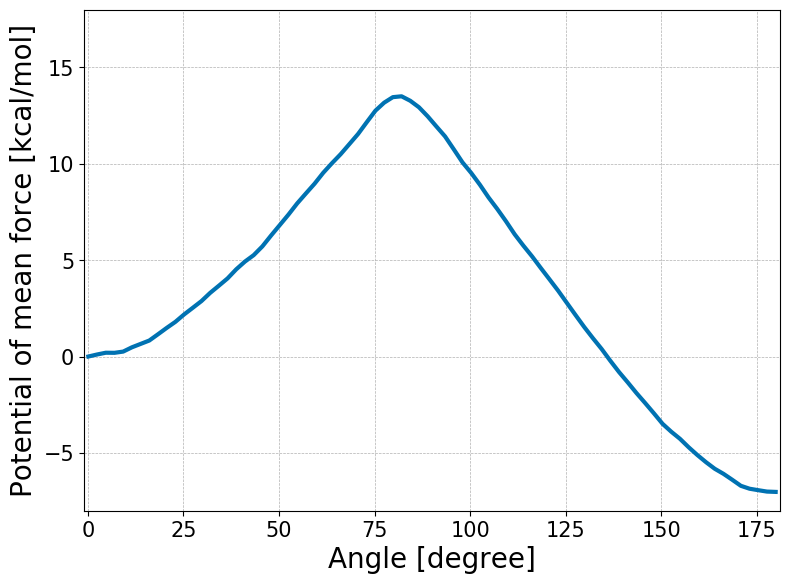

In [18]:
fig, ax = subplots(figsize=(8, 6))
ax[:plot](bin_center, pmf[:], linewidth=3)
xlabel("Angle [degree]",fontsize=20)
ylabel("Potential of mean force [kcal/mol]",fontsize=20)

# detailed options (not necessary, just for reference)
ax[:set](xlim=[-1, 181], ylim=[-8, 18])
ax[:grid](linestyle="--", linewidth=0.5)
ax[:xaxis][:set_tick_params](which="major",labelsize=15)
ax[:yaxis][:set_tick_params](which="major",labelsize=15)
ax[:grid](linestyle="--", linewidth=0.5)
tight_layout()

savefig("LinearRegression.png", dpi=350)